In [1]:
import pandas as pd
import json
import glob
from gensim.models import Word2Vec
import math
import re
from scipy.stats import spearmanr
from sklearn.metrics import accuracy_score

from bokeh.plotting import figure, show
from bokeh.transform import factor_cmap, factor_mark
from bokeh.models import Span

from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row, gridplot
from bokeh.plotting import figure, show, output_file
output_notebook()

Loading BokehJS ...

### Funs

In [2]:
def accuracy(pretrained, model):
    if (len(pretrained) != len(model)):
        raise Exception("Count of expert and model ratings are not equal!")
    else:
        y_true = []
        y_pred = []

        for item in pretrained:
            if item > 0.5:
                y_true.append(1)
            else:
                y_true.append(0)

        for item in model:
            if item > 0.5:
                y_pred.append(1)
            else:
                y_pred.append(0)

        score = accuracy_score(y_true, y_pred)
        return score

### Eval List

In [44]:
pathEval = "/home/hiwi/Dokumente/masterthesis/data/terminology/eval_extrinsic.json"
evalList = json.loads(open(pathEval).read())["eval_list"]

### Results: Pretrained model

In [45]:
path = "/home/hiwi/Dokumente/masterthesis/data/eval/results_part4_12_03.csv"
data = pd.read_csv(path, sep=";")
data.score = data.score.astype(float)

## Data - part 2

### Load Models

In [46]:
pathModels = "/home/hiwi/Dokumente/masterthesis/data/trained/"
models2 = glob.glob(pathModels+"w2v_ngramsTraining*.bin")

In [47]:
results2 = {}

for model in models2:
    scores = []
    modelCurrent = Word2Vec.load(model)
    for i in range(0, len(evalList)-1):
        term1 = evalList[i]
        for j in range(i+1, len(evalList)):
            term2 = evalList[j]

            try:
                score = modelCurrent.similarity(term1, term2)
                scores.append(score)
            except:
                score = float("NaN")
                scores.append(score)
    start = model.find("w2v")
    modelName = model[start:]
    results2[modelName] = scores

results2DF = pd.DataFrame.from_dict(results2)

In [94]:
dataPart2 = pd.concat([data, results2DF], axis=1, sort=False)
#dataPart2 = dataPart2[dataPart2.score > 0.5]

In [95]:
dataPart2.shape

(6903, 195)

### Results: Intrinsic eval

In [96]:
pathIntrinsic2 = "/home/hiwi/Dokumente/masterthesis/data/trained/w2v_trainingLog_part2_11_26.csv"
dataIntrinsic2 = pd.read_csv(pathIntrinsic2, sep=";")
dataIntrinsic2["modelName"] = ""

for i, row in dataIntrinsic2.iterrows():
    vs = dataIntrinsic2.at[i, "vectorSize"]
    win = dataIntrinsic2.at[i, "window"]
    mc = dataIntrinsic2.at[i, "minCount"]
    sg = int(dataIntrinsic2.at[1, "trainAlgorithm"] == "skipgram")
    hs = int(dataIntrinsic2.at[1, "methodSampl"] == "softmax")
    name = f"w2v_ngramsTraining_vs{vs}_win{win}_mc{mc}_sg{sg}_hs{hs}.bin"
    dataIntrinsic2.at[i, "modelName"] = name

In [97]:
pathIntrinsicResults2 = "/home/hiwi/Dokumente/masterthesis/data/eval/results_part2_01b_12_01.csv"
dataIntrinsicResults2 = pd.read_csv(pathIntrinsicResults2, sep=";")

dataIntrinsic2 = pd.concat([dataIntrinsic2, dataIntrinsicResults2], axis=1, sort=False)

### Results: Extrinsic eval

In [98]:
dataIntrinsic2["scoresExtr"] = ""
#dataIntrinsic2["scoresExtr_accur2"] = ""

for i, row in dataIntrinsic2.iterrows():
    model = dataIntrinsic2.at[i, "modelName"]
    score = spearmanr(dataPart2["score"], dataPart2[model], nan_policy="omit")[0]
    #accur = accuracy(dataPart2["score"], dataPart2[model])
    dataIntrinsic2.at[i, "scoresExtr"] = score
    #dataIntrinsic2.at[i, "scoresExtr_accur2"] = accur

### Comparison: Intrinsic eval vs. Extrinsic eval

In [99]:
dataPlot = dataIntrinsic2.loc[:,~dataIntrinsic2.columns.duplicated()]
#dataPlot = dataPlot[(dataPlot.vectorSize==300) & (dataPlot.methodSampl=="negSampl")]
#dataPlot = dataPlot[(dataPlot.vectorSize==300) | (dataPlot.vectorSize==500) & (dataPlot.methodSampl=="softmax")]
#dataPlot = dataPlot.sort_values(by=["evalScore"])
"""
dataPlot = dataPlot[(dataPlot.methodSampl=="negSampl") & 
                            #(dataPlot.trainAlgorithm=="skipgram") & 
                            (dataPlot.vectorSize==300)]

dataPlot = dataIntrinsic2[(dataIntrinsic2.vectorSize==300)]
"""

'\ndataPlot = dataPlot[(dataPlot.methodSampl=="negSampl") & \n                            #(dataPlot.trainAlgorithm=="skipgram") & \n                            (dataPlot.vectorSize==300)]\n\ndataPlot = dataIntrinsic2[(dataIntrinsic2.vectorSize==300)]\n'

In [100]:
dataPlot[:5]

,id,reduction,rare,shuffle,ngrams,vectorSize,window,minCount,trainAlgorithm,methodSampl,modelName,aggregation,cosistencyCheck,scoreType,countPairs,evalScore,scoresExtr
0,1,lemma,True,True,training,50,2,0,CBOW,softmax,w2v_ngramsTraining_vs50_win2_mc0_sg1_hs1.bin,majorityWeighted,True,accuracy score,638,0.564263,0.319474
1,2,lemma,True,True,training,50,2,0,skipgram,softmax,w2v_ngramsTraining_vs50_win2_mc0_sg1_hs1.bin,majorityWeighted,True,accuracy score,638,0.468652,0.319474
2,3,lemma,True,True,training,50,2,0,CBOW,negSampl,w2v_ngramsTraining_vs50_win2_mc0_sg1_hs1.bin,majorityWeighted,True,accuracy score,638,0.401254,0.319474
3,4,lemma,True,True,training,50,2,0,skipgram,negSampl,w2v_ngramsTraining_vs50_win2_mc0_sg1_hs1.bin,majorityWeighted,True,accuracy score,638,0.340125,0.319474
4,5,lemma,True,True,training,50,2,5,CBOW,softmax,w2v_ngramsTraining_vs50_win2_mc5_sg1_hs1.bin,majorityWeighted,True,accuracy score,638,0.562696,0.317682


In [15]:
path = '/home/hiwi/Dokumente/masterthesis/notes/'
dataPlot.to_csv(path+'temp.csv', index=False) 

In [203]:
evalScore = dataPlot.evalScore
scoresExtr = dataPlot.scoresExtr
scoresExtr_accur = dataPlot.scoresExtr_accur
ids = range(len(evalScore))

p = figure(title="Training Part 4: Intrinsic vs. Extrinsic")
p.xaxis.axis_label = "Models"
p.yaxis.axis_label = "Eval score"

#p.line(ids, evalScore)
#p.line(ids, scoresExtr, color="red")
#p.line(ids, scoresExtr_accur, color="green")

p.scatter("id", "evalScore", source=dataPlot)
p.line("id", "evalScore", source=dataPlot)
p.scatter("id", "scoresExtr", source=dataPlot, color="red")
p.line("id", "scoresExtr", source=dataPlot, color="red")

show(p)

### Plots

In [101]:
dataTemp = dataPlot[["evalScore", "scoresExtr"]]
dataTemp[:3]

,evalScore,scoresExtr
0,0.564263,0.319474
1,0.468652,0.319474
2,0.401254,0.319474


In [102]:
dataTemp = dataTemp.sort_values(by=["evalScore"])

In [103]:
dataTemp["id"] = range(1, 1+len(dataTemp))
dataTemp[:3]

,evalScore,scoresExtr,id
3,0.340125,0.319474,1
7,0.343260,0.317682,2
23,0.362069,0.31816,3


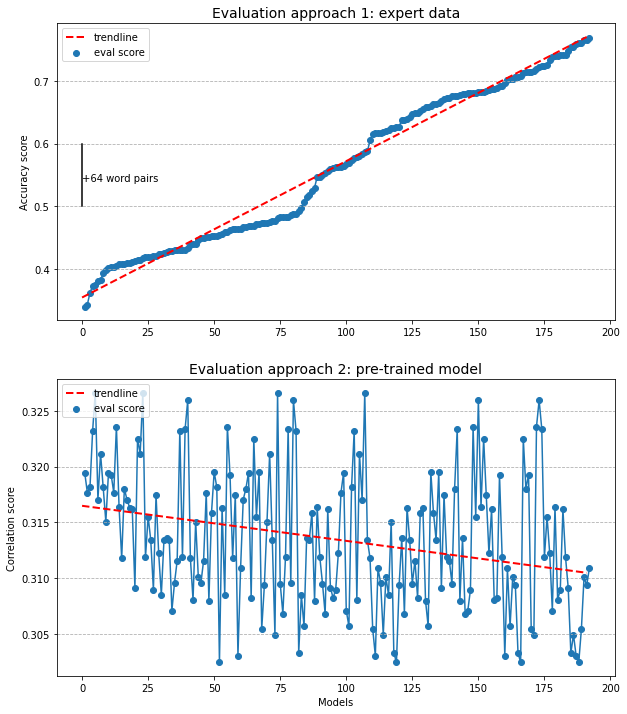

In [109]:
import matplotlib.pyplot as plt
import numpy as np

#X = np.array(dataTemp.id)
X = np.array(range(len(dataTemp.id)))
X = X.astype(np.float64)
fig, ax = plt.subplots(2,1, figsize=(10, 12))

ax[0].scatter(data=dataTemp, x="id", y="evalScore", label="eval score")
ax[0].plot(dataTemp.id, dataTemp.evalScore)
ax[0].set_title('Evaluation approach 1: expert data', fontsize=14)
intrinsic = np.array(dataTemp.evalScore)
z = np.polyfit(X, intrinsic, 1)
p = np.poly1d(z)
ax[0].plot(X,p(X),"r--", linewidth=2.0, label="trendline")

ax[0].grid(True, axis="y", linestyle="--")
ax[0].set_ylabel("Accuracy score")
ax[0].plot([0, 0], [0.5, 0.6], color="k")
ax[0].text(0.03, 0.54, "+64 word pairs")
ax[0].legend(loc="upper left")

ax[1].scatter(data=dataTemp, x="id", y="scoresExtr", label="eval score")
ax[1].plot(dataTemp.id, dataTemp.scoresExtr)
ax[1].set_title('Evaluation approach 2: pre-trained model', fontsize=14)
extrinsic = np.array(dataTemp.scoresExtr)
extrinsic = extrinsic.astype(np.float64)
z = np.polyfit(X, extrinsic, 1)
p = np.poly1d(z)
ax[1].plot(X,p(X),"r--", linewidth=2.0, label="trendline")

ax[1].grid(True, axis="y", linestyle="--")
ax[1].set_xlabel("Models")
ax[1].set_ylabel("Correlation score")
ax[1].legend(loc="upper left")
#ax[1].plot([0, 0], [0.305, 0.310], color="k")
#ax[1].text(0.03, 0.307, "+35 word pairs")

In [69]:
spearmanr(dataPlot.evalScore, dataPlot.scoresExtr, nan_policy="omit")

SpearmanrResult(correlation=-0.2919884833800653, pvalue=3.966829558526865e-05)

In [71]:
spearmanr(dataPlot.evalScore, dataPlot.scoresExtr2, nan_policy="omit")

SpearmanrResult(correlation=-0.13744592766603891, pvalue=0.05728855734939114)

In [206]:
dataPlot["groupMethod"] = dataPlot.groupby(["vectorSize", "window", "minCount", "trainAlgorithm"]).ngroup()

# Check performance: softmax vs. negative sampling

methods = ["softmax", "negSampl"]
markers = ["hex", "triangle"]

p = figure(title="Training Part 2: Evaluation results")
p.xaxis.axis_label = "Constant Groups"
p.yaxis.axis_label = "Eval score"

p.scatter("groupMethod", "scoresExtr", source=dataPlot, legend_field="methodSampl", fill_alpha=0.4, size=10,
            marker=factor_mark("methodSampl", markers, methods),
            color=factor_cmap("methodSampl", "Category10_3", methods))

p.add_layout(p.legend[0], "right")

show(p)

In [207]:
dataPlot["groupAlgo"] = dataPlot.groupby(["vectorSize", "window", "minCount", "methodSampl"]).ngroup()

# Check performance: CBOW vs. skipgram

methods = ["CBOW", "skipgran"]
markers = ["hex", "triangle"]

p = figure(title="Training Part 2: Evaluation results")
p.xaxis.axis_label = "Constant Groups"
p.yaxis.axis_label = "Eval score"

p.scatter("groupAlgo", "scoresExtr", source=dataPlot, legend_field="trainAlgorithm", fill_alpha=0.4, size=10,
            marker=factor_mark("trainAlgorithm", markers, methods),
            color=factor_cmap("trainAlgorithm", "Category10_3", methods))

p.add_layout(p.legend[0], "right")

show(p)

In [208]:
dataPlot["scoresExtr"] = dataPlot["scoresExtr"].astype(np.float64)
dataPlot.nlargest(50, 'evalScore')

,id,reduction,rare,shuffle,ngrams,vectorSize,window,minCount,trainAlgorithm,methodSampl,modelName,aggregation,cosistencyCheck,scoreType,countPairs,evalScore,scoresExtr,scoresExtr_accur,groupMethod,groupAlgo
131,132,lemma,True,True,training,300,10,0,skipgram,negSampl,w2v_ngramsTraining_vs300_win10_mc0_sg1_hs1.bin,majorityWeighted,True,accuracy score,638,0.626959,0.309346,0.989859,17,8
143,144,lemma,True,True,training,300,10,50,skipgram,negSampl,w2v_ngramsTraining_vs300_win10_mc50_sg1_hs1.bin,majorityWeighted,True,accuracy score,638,0.625392,0.303290,0.990584,23,11
139,140,lemma,True,True,training,300,10,20,skipgram,negSampl,w2v_ngramsTraining_vs300_win10_mc20_sg1_hs1.bin,majorityWeighted,True,accuracy score,638,0.617555,0.303052,0.990439,21,10
135,136,lemma,True,True,training,300,10,5,skipgram,negSampl,w2v_ngramsTraining_vs300_win10_mc5_sg1_hs1.bin,majorityWeighted,True,accuracy score,638,0.615987,0.305458,0.990149,19,9
127,128,lemma,True,True,training,300,5,50,skipgram,negSampl,w2v_ngramsTraining_vs300_win5_mc50_sg1_hs1.bin,majorityWeighted,True,accuracy score,638,0.578370,0.308067,0.990439,15,7
123,124,lemma,True,True,training,300,5,20,skipgram,negSampl,w2v_ngramsTraining_vs300_win5_mc20_sg1_hs1.bin,majorityWeighted,True,accuracy score,638,0.562696,0.308958,0.990439,13,6
115,116,lemma,True,True,training,300,5,0,skipgram,negSampl,w2v_ngramsTraining_vs300_win5_mc0_sg1_hs1.bin,majorityWeighted,True,accuracy score,638,0.556426,0.316190,0.990584,9,4
119,120,lemma,True,True,training,300,5,5,skipgram,negSampl,w2v_ngramsTraining_vs300_win5_mc5_sg1_hs1.bin,majorityWeighted,True,accuracy score,638,0.547022,0.311857,0.990439,11,5
142,143,lemma,True,True,training,300,10,50,CBOW,negSampl,w2v_ngramsTraining_vs300_win10_mc50_sg1_hs1.bin,majorityWeighted,True,accuracy score,638,0.492163,0.303290,0.990584,22,11
111,112,lemma,True,True,training,300,2,50,skipgram,negSampl,w2v_ngramsTraining_vs300_win2_mc50_sg1_hs1.bin,majorityWeighted,True,accuracy score,638,0.487461,0.325965,0.990584,7,3


### Appex

In [209]:
dataPlot[:4]

,id,reduction,rare,shuffle,ngrams,vectorSize,window,minCount,trainAlgorithm,methodSampl,modelName,aggregation,cosistencyCheck,scoreType,countPairs,evalScore,scoresExtr,scoresExtr_accur,groupMethod,groupAlgo
98,99,lemma,True,True,training,300,2,0,CBOW,negSampl,w2v_ngramsTraining_vs300_win2_mc0_sg1_hs1.bin,majorityWeighted,True,accuracy score,638,0.402821,0.319289,0.990729,0,0
99,100,lemma,True,True,training,300,2,0,skipgram,negSampl,w2v_ngramsTraining_vs300_win2_mc0_sg1_hs1.bin,majorityWeighted,True,accuracy score,638,0.462382,0.319289,0.990729,1,0
102,103,lemma,True,True,training,300,2,5,CBOW,negSampl,w2v_ngramsTraining_vs300_win2_mc5_sg1_hs1.bin,majorityWeighted,True,accuracy score,638,0.407524,0.318022,0.990584,2,1
103,104,lemma,True,True,training,300,2,5,skipgram,negSampl,w2v_ngramsTraining_vs300_win2_mc5_sg1_hs1.bin,majorityWeighted,True,accuracy score,638,0.467085,0.318022,0.990584,3,1


In [210]:
test = float("NaN")
math.isnan(test)


testS = "/home/hiwi/Dokumente/masterthesis/data/trained/w2v_ngramsTraining*.bin"

start = testS.find("w2v")
testS[start:]

'w2v_ngramsTraining*.bin'